# Game Prototype of Team Scotland #2
Felix Zaussinger, Martina Buck | 01.12.2020, 15:30

======================================================================================================================

                                            GAME CONFIGURATION

======================================================================================================================

**Magic commands**

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

**External imports**

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import configparser
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

**Figure properties**

In [3]:
sns.set_context("poster")
sns.set(rc={'figure.figsize': (8, 5)})
sns.set_style("ticks")

**Directory structure**

In [4]:
# project directory
abspath = os.path.abspath('')
project_dir = str(Path(abspath).parents[0])

# sub-directories
data_raw = os.path.join(project_dir, "data", "raw")
data_processed = os.path.join(project_dir, "data", "processed")
figure_dir = os.path.join(project_dir, "plots")
project_dir

'/Users/felix/ETH/code/gecm'

**Append project directory to PYTHONPATH via sys (!)**

Source: https://stackoverflow.com/questions/39299838/how-do-i-import-module-in-jupyter-notebook-directory-into-notebooks-in-lower-dir

In [5]:
if project_dir not in sys.path:
    sys.path.append(project_dir)

#### import our own code from src

In [6]:
from src.gecm import model, vis, io, game, base, dicts
from src.gecm.field import Map
from src.gecm.dicts import (
        original_lulc_mapping,
        lulc_remapping,
        simplified_lulc_mapping,
        simplified_lulc_mapping_colors
    )

#### Game parameters

In [7]:
# size of playing field in pixels
n_pixels = 40

# complexity of playing field (only granularity = 1 works for now)
granularity = 1

# colormap
simplified_lulc_cm = ListedColormap(
    [simplified_lulc_mapping_colors[x] for x in simplified_lulc_mapping_colors.keys()]
)

# path to raster data file (must be a geotiff)
fpath_map = os.path.join(
    data_processed, "NFI_rasterized_{}_{}.tif".format(n_pixels, n_pixels)
)

#### Configuration file

In [8]:
# init config file parser. methods: config.getboolean, config.getint, ... .
config = configparser.ConfigParser()
fpath_cf = os.path.join(project_dir, 'config.ini')
config.read(fpath_cf)

# Show configuration file sections
io.config_describe(config)


--- default ---
credentials: 'google_api_credentials.json'
scopes: https://www.googleapis.com/auth/spreadsheets.readonly

--- gdrive_spreadsheet_ids ---
spreadsheet_id_farmers: 1kEEcKdP__1XbYKe5-nVlxzAD_P5-EQx-23IAw9SXOoc
spreadsheet_id_foresters: 1ir8WkfKpyEGkamASbd0pf9IDAE74M4Q1fsHYl4r9F34
spreadsheet_id_tourism: 1EA_mCM9Pp_URb_JavM-mMIqixTvZewSkGC2b-wDa1ns
spreadsheet_id_model: 1CVdDndGD1S8ab3D1KlXYcBcnjK8sBPl68Eth0KMgaEQ

--- gdrive_sheet_names ---
sheet_names_farmers: Farmer_1, Farmer_2
sheet_names_foresters: Forester_1, Forester_2
sheet_names_tourism: SSDA
sheet_names_model: model_parameters, model_calculations


#### Google Drive Connection

In [9]:
# If modifying these scopes, delete the file token.pickle.
SCOPES = [config.get(section="default", option="scopes")]

# API credentials
credentials_fpath = os.path.join(project_dir, 'google_api_credentials.json')

#### Conceptual model

In [10]:
%reload_ext autoreload
model_settings_dict = io.parse_sheets(
        spreadsheet_id=config.get(section="gdrive_spreadsheet_ids", option="spreadsheet_id_model"), 
        sheets=io.parse_list(config_string=config.get(section="gdrive_sheet_names", option="sheet_names_model")),
        credentials_fpath=credentials_fpath, 
        scopes=SCOPES,
        to_numeric=True
    )

# extract model_parameters as dictionary
model_parameters_dict = model_settings_dict["model_parameters"].loc[:, ["variable", "value"]].set_index("variable").to_dict()["value"]

# add to local namespace
# quick-fix based on: https://stackoverflow.com/questions/4357851/creating-or-assigning-variables-from-a-dictionary-in-python
# alternative: 
# for k,v in d.items(): 
#    vars()[k] = v 
locals().update(model_parameters_dict)

# add model_parameters to config file
config['model_parameters'] = model_parameters_dict

# display contents of config file
io.config_describe(config)

model_parameters
model_calculations

--- default ---
credentials: 'google_api_credentials.json'
scopes: https://www.googleapis.com/auth/spreadsheets.readonly

--- gdrive_spreadsheet_ids ---
spreadsheet_id_farmers: 1kEEcKdP__1XbYKe5-nVlxzAD_P5-EQx-23IAw9SXOoc
spreadsheet_id_foresters: 1ir8WkfKpyEGkamASbd0pf9IDAE74M4Q1fsHYl4r9F34
spreadsheet_id_tourism: 1EA_mCM9Pp_URb_JavM-mMIqixTvZewSkGC2b-wDa1ns
spreadsheet_id_model: 1CVdDndGD1S8ab3D1KlXYcBcnjK8sBPl68Eth0KMgaEQ

--- gdrive_sheet_names ---
sheet_names_farmers: Farmer_1, Farmer_2
sheet_names_foresters: Forester_1, Forester_2
sheet_names_tourism: SSDA
sheet_names_model: model_parameters, model_calculations

--- model_parameters ---
income_farmland_sheep: 30
income_farmland_cattle: 100
income_forest_commercial: 200
income_forest_native: 50
gdp_tourism: 43952
gdp_average: 29600
income_farm: 39000
unempl_rate_scotland: 5
unempl_rate_scotland_west: 5
bank_account_farmer_1: 10000
bank_account_farmer_2: 10000
bank_account_forestry_1: 10000
bank

#### Playing field

In [11]:
%reload_ext autoreload
playing_field = Map(
    fpath=fpath_map,
    original_lulc_mapping=original_lulc_mapping,
    simplified_lulc_mapping=simplified_lulc_mapping,
    lulc_remapping=lulc_remapping,
    cmap=simplified_lulc_cm,
    model_param_dict=model_parameters_dict,
    model_calc_dict=None
)

# initialise playing field (crucial, else nothing works!)
playing_field.initialise(granularity=1)

# sanity check on current round
assert playing_field.current_round == 0

======================================================================================================================

                                            START OF ACTUAL GAME

======================================================================================================================

### Starting Point ("Round 0")

####  Dashboard

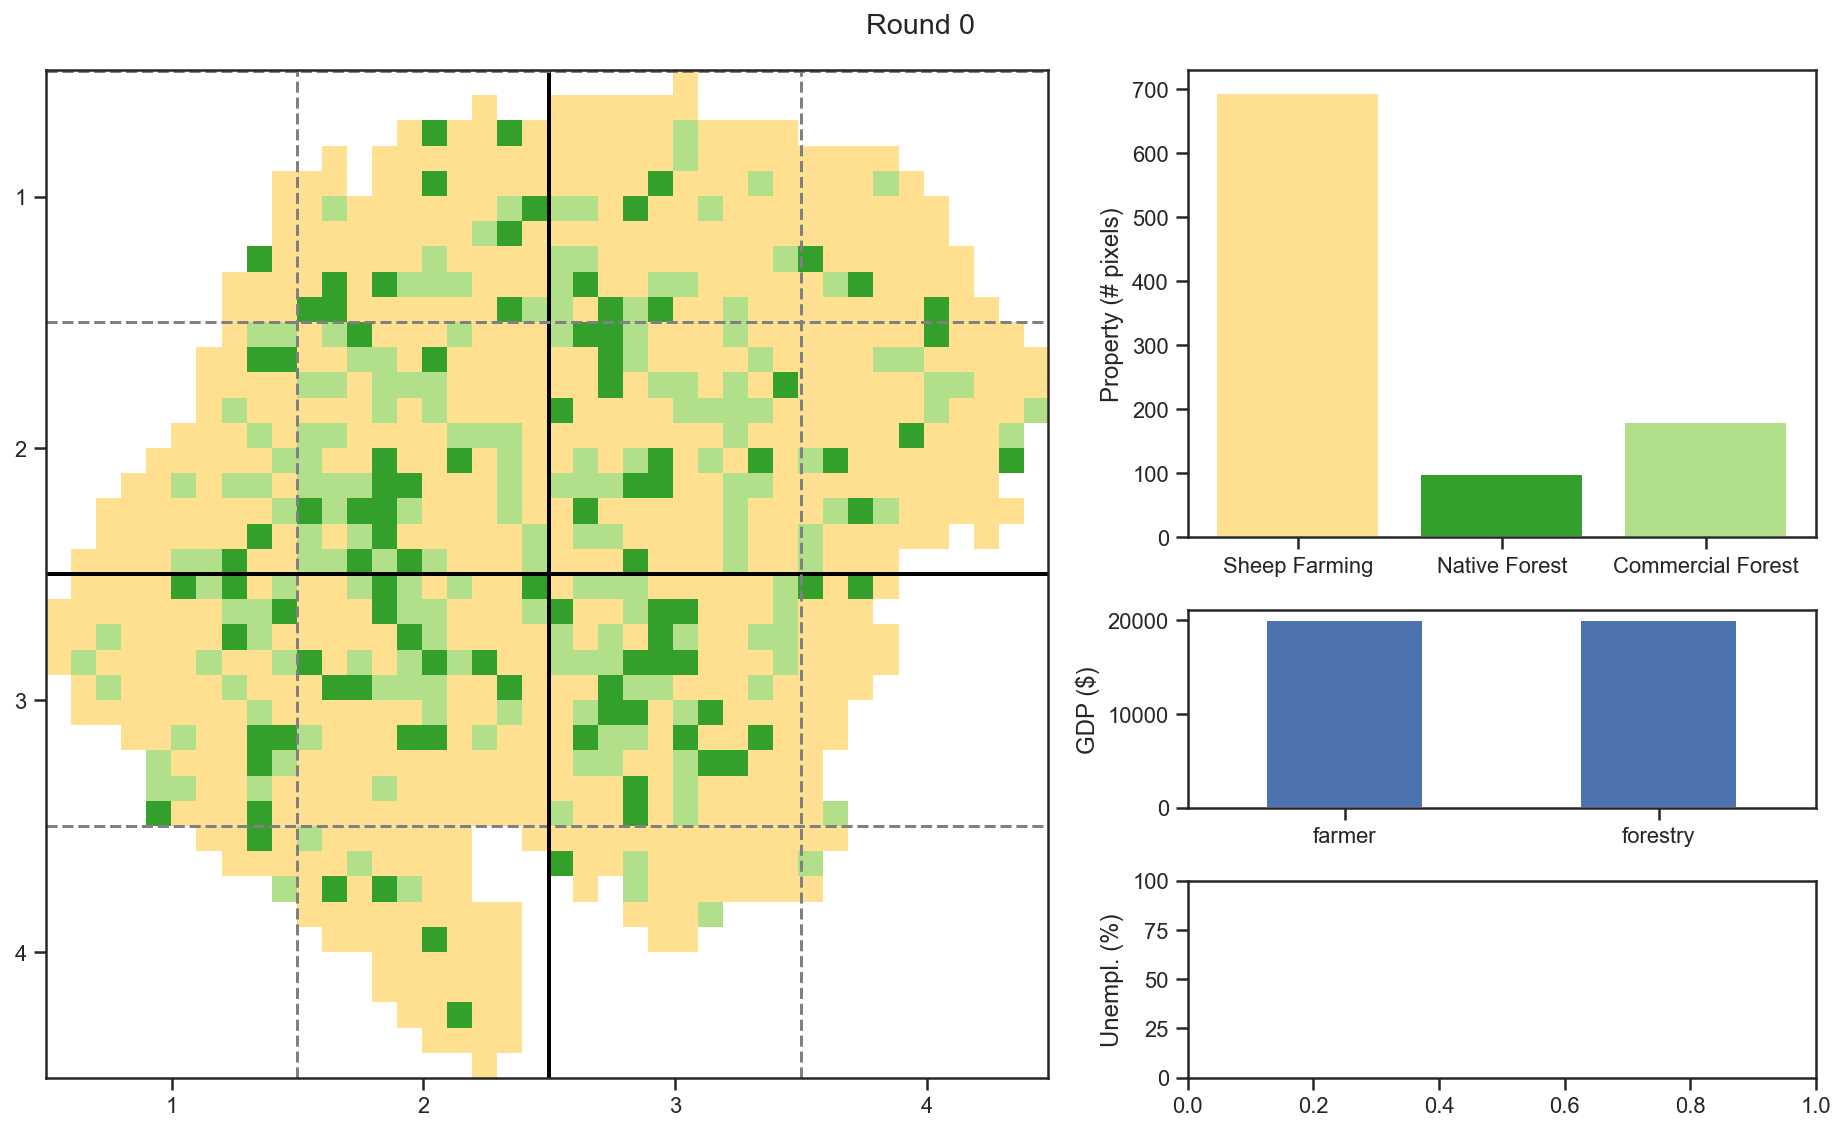

In [12]:
%reload_ext autoreload
playing_field.show_dashboard(figure_size=(13,8))

### Round 1

#### 1. Downloading management decisions

Farmer_1
Farmer_2
Forester_1
Forester_2
SSDA
CPU times: user 1.73 s, sys: 225 ms, total: 1.96 s
Wall time: 8.57 s


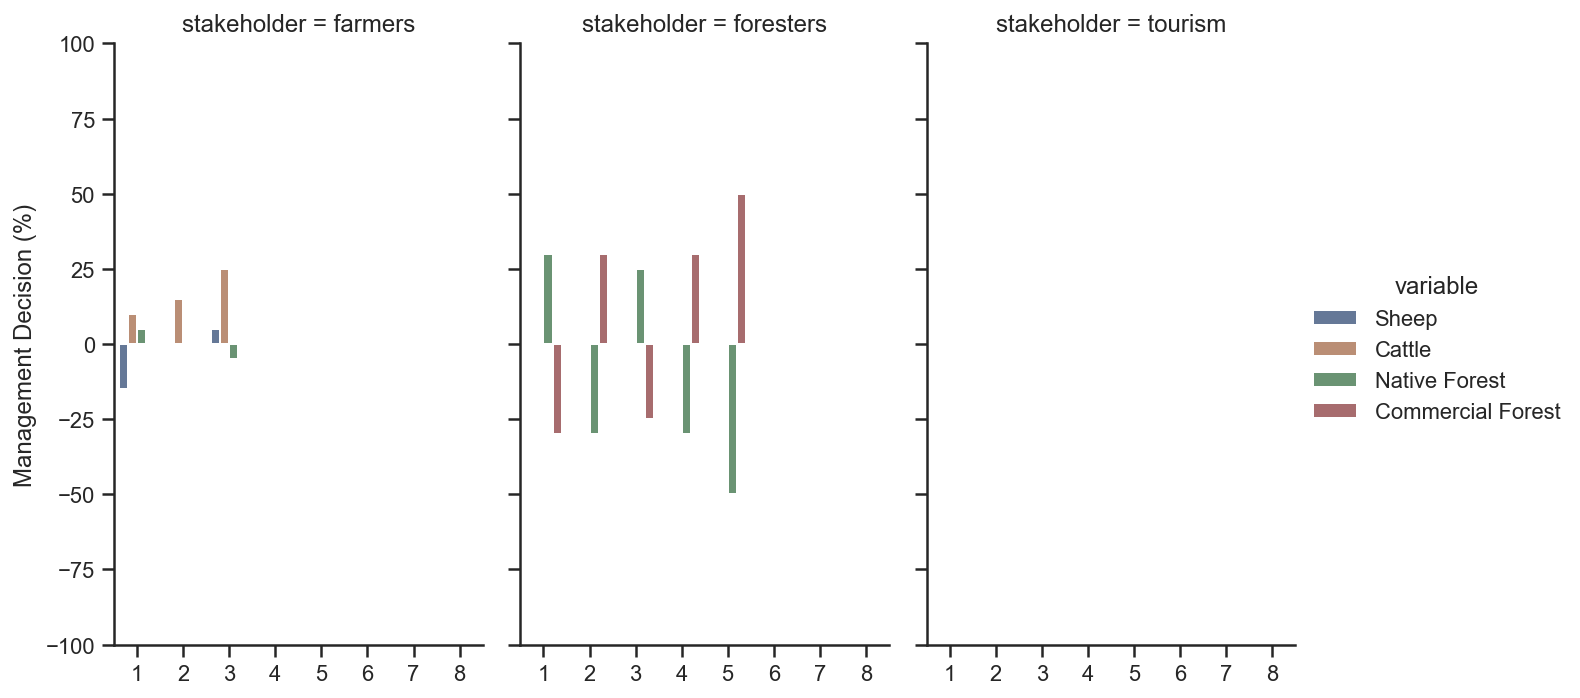

In [13]:
%%time

# parse
dict_of_mgmt_decisions_dfs = {}
for stakeholder_group in ["farmers", "foresters", "tourism"]:
    dict_of_mgmt_decisions_dfs[stakeholder_group] = io.parse_mgmt_decisions(
        spreadsheet_id=config.get(section="gdrive_spreadsheet_ids", option="spreadsheet_id_{}".format(stakeholder_group)), 
        sheets=io.parse_list(config_string=config.get(section="gdrive_sheet_names", option="sheet_names_{}".format(stakeholder_group))),
        credentials_fpath=credentials_fpath, 
        scopes=SCOPES, 
        unstack_data=False
    )
    
# combine
df_mgmt_decisions = pd.concat(dict_of_mgmt_decisions_dfs.values(), keys=dict_of_mgmt_decisions_dfs.keys())
df_mgmt_decisions.index.rename("stakeholder", level=0, inplace=True)
df_mgmt_decisions_long = df_mgmt_decisions.reset_index()
df_mgmt_decisions_long["id"] = df_mgmt_decisions_long.index.values

# melt
id_vars = ["stakeholder", "round", "player", "Plot", "Teamwork"]
value_vars = ["Sheep", "Cattle", "Native Forest", "Commercial Forest"]
df_mgmt_decisions_melted = df_mgmt_decisions_long.melt(id_vars=id_vars, value_vars=value_vars)

# visualize
# https://seaborn.pydata.org/tutorial/relational.html: seaborn supports semantics of hue, size, and style
g = sns.catplot(x="round", y="value", hue="variable", col="stakeholder", kind="bar", data=df_mgmt_decisions_melted, saturation=.5, ci=None, aspect=.6)

(g.set_axis_labels("", "Management Decision (%)")
 #.set_xticklabels(["round", "round", "round"])
 #.set_titles("{col_name} {col_var}")
 .set(ylim=(-100, 100)).despine(left=False))

#### 2. Calculating Income & updating Bank Accounts

In [ ]:
# TODO: MARTINA

#### 3. Updating dashboard (reflect changes in landscape, property allocation, GDP and unemployment)

In [14]:
# TODO: FELIX
playing_field.map_simplified

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=255,
  dtype=uint8)

#### 4. Updating round number

In [15]:
%reload_ext autoreload
playing_field.update_round_number()

## Round 2

#### 0. Sanity check on round number

In [16]:
%reload_ext autoreload
assert playing_field.get_rounds(True) == 1

#### 1. Downloading management decisions

## Round 3

# Code graveyard

#### Yield calculation

In [17]:
%reload_ext autoreload
# calc number of pixels per stakeholder
global_yield = model.calculate_yield(
    field=playing_field.map_simplified,
    lulc_mapping=playing_field.simplified_lulc_mapping,
    relative=False
)

# transform data
global_yield_remapped = dict(zip(playing_field.simplified_lulc_mapping.keys(), list(global_yield.values())))
df_global_yield_remapped = pd.DataFrame(global_yield_remapped, index=["yield"]).transpose()

# plot
# df_global_yield_remapped.plot.bar()